In [47]:
import numpy as np
import pandas as pd
from math import trunc
import pickle
import copy
import random
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,precision_score

import matplotlib.pyplot as plt
%matplotlib inline

In [128]:
#vocRounding is used to truncate the VOCs to 3dp allowing for flexible matching between 2013 and 2015 datasets
def vocRounding(vocDf):
    vocList = list()
    for index in range(0, len(vocDf.columns)):
        if vocDf.columns[index] == 'Time' or vocDf.columns[index] == 'ocs' or vocDf.columns[index] == 'co' or vocDf.columns[index] == 'CO2':
            vocList.append(vocDf.columns[index])    
        else:
            #string slice to get the molar mass
            voc = vocDf.columns[index]
            mass = (trunc(float(voc[1:])*1000))/1000 #TRUNCATE TO 3DP
            vocList.append(mass)
    return vocList

#generate normalised screenings
#remove invalid screenings (divide by NaN or divide by 0)
#scale vocs between 0 and 1
def generateNormalisedScreenings(sliceDict, vocData):
    screeningList = list()
    matchedMovies = list()
    for index in range(0,sliceDict['sliceDf'].shape[0]):
        start,end = sliceDict['sliceDf'].loc[index]
        screening = vocData[start:end+1]
        normalisedFrame = copy.deepcopy(screening)
        if max(normalisedFrame.values) != 0 and not(np.isnan(max(normalisedFrame.values))):
            normalisedFrame = normalisedFrame.values.reshape(-1,1)
            scaler = MinMaxScaler()
            normalisedFrame = scaler.fit_transform(normalisedFrame)
            normalisedFrame = np.transpose(normalisedFrame)
            screeningList.append(normalisedFrame)
            matchedMovies.append(sliceDict['matchedMovies'][index])
    return screeningList, matchedMovies

#train test split - one movie is left out for the test set 
def movieTrainTestSplit(movieList,matchedMovies,screeningList):
    
    testScreeningList = list()
    testMovieList = list()
    testMovie = movieList[random.randint(0, len(movieList)-1)] #pick random test movie 
    while True:
        try:
            matchedIndex = matchedMovies.index(testMovie)
            screening = screeningList.pop(matchedIndex)
            testScreeningList.append(screening)
            matchedMovie = matchedMovies.pop(matchedIndex)
            testMovieList.append(testMovie)
        except ValueError:
            break
    
    return testScreeningList,testMovieList,screeningList,matchedMovies


def inputOutputDf(screeningList):
    
    #input - 9 vocs
    #output - 1 voc 
    
    deltaDf = np.array([])
    inputDf = np.array([])
    info = np.array([])
    for screening in screeningList:
        
        #Calculate deltas
        percentageChange = np.array([(screening[0,x+1] - screening[0,x])/screening[0,x] for x in range(8,screening.shape[1]-1)])
        percentageChange[np.isinf(percentageChange)] = 0
        #get categorical values
        # 1 up
        # 0 no change
        # -1 down
        outputLabels = categoricalValues(percentageChange)
        
        #AR VOC Input
        screening = screening[0] #remove the 1st dimension
        listOfInstances = [screening[x:x+9] for x in range(0,len(screening))]
        inputDf = np.array([])
        for instance in listOfInstances:
            if len(instance) == 9:
                if inputDf.size == 0:
                    inputDf = instance
                else:
                    inputDf = np.vstack((inputDf,instance))

        #add labels to the output
        #cut off last row (as cannot predict it)
        inputDf = inputDf[:-1]

        #connect the input to output
        if info.size == 0: 
            info = np.hstack((inputDf,np.expand_dims(outputLabels, axis=1)))
        else:
            instance = np.hstack((inputDf,np.expand_dims(outputLabels, axis=1)))
            info = np.vstack((info,instance))

    return info

def categoricalValues(percentageChange):

    percentageChangeFlatUpperLimit = 0.02
    percentageChangeFlatLowerLimit = -0.02
    # calculate percetange change between 2 values to get the output label
    #categories - 'no change', 'up', 'down'
    #up = 1
    #down = -1
    #no change = 0

    outputLabels = np.zeros(percentageChange.shape[0])
    #up category
    upMask = np.greater_equal(percentageChange, percentageChangeFlatUpperLimit)
    outputLabels[upMask] = 1
    #down category
    downMask = np.less_equal(percentageChange, percentageChangeFlatLowerLimit)
    outputLabels[downMask] = -1
    
    return outputLabels

def ClassificationModel(featuresTrain,labelsTrain, labelsTest,featuresTest):
    print('Train Model')
    clf = RandomForestClassifier(n_estimators=100)
    clf.fit(featuresTrain, labelsTrain)  
    
    print('Test Model')
    predictedLabels = clf.predict(featuresTest)
    
    #compute accuracy and precision
    precisionScore = precision_score(labelsTest, predictedLabels, average='micro')
    accuracyScore = accuracy_score(labelsTest, predictedLabels)
    
    return precisionScore,accuracyScore

In [102]:
#CREATE VOC DF

#import various numeric csvs
vocPath = 'Numerical Data/2013VOCData.csv'
voc2013DfAll = pd.read_csv(vocPath, header = 0, nrows = 74208, low_memory=False)
movieScreeningsPath = 'Numerical Data/screening_times.csv'
movingScreeningsDf = pd.read_csv(movieScreeningsPath, usecols = ['scheduled','movie','filled %'])
movieRuntimesPath = 'Numerical Data/movie_runtimes.csv'
movieRuntimeDf = pd.read_csv(movieRuntimesPath, usecols = ['movie', 'runtime (mins)', 'effective runtime'])
#2015 Dataset
starWarsPath = 'Numerical Data/Star Wars-The Force Awakens.csv'
starWarsScreeningDf = pd.read_csv(starWarsPath)
imOffThenPath = 'Numerical Data/I\'m Off Then.csv'
imOffThenScreeningDf = pd.read_csv(imOffThenPath)
helpIShrunkTheTeacherPath = 'Numerical Data/Help, I Shrunk My Teacher.csv'
helpIShrunkTheTeacherScreeningDf = pd.read_csv(helpIShrunkTheTeacherPath)
vocPath = 'Numerical Data/2015VOCData.csv'
voc2015DfAll = pd.read_csv(vocPath)
#remove first column of 2015 voc df as its not used
voc2015DfAll.drop("Unnamed: 0", axis=1, inplace=True)

#full list of movies
movieList = list(movieRuntimeDf['movie'])


#import the slicing indices
slicePath = 'Pickle Objects/VocSlices.p'
sliceDict = pickle.load(open(slicePath, "rb" )) #contains df of co2 slice indices and matched movie list

#round the vocs
voc2015Col = vocRounding(voc2015DfAll)
voc2013Col = vocRounding(voc2013DfAll)
voc2013Df = copy.deepcopy(voc2013DfAll)
voc2015Df = copy.deepcopy(voc2015DfAll)
voc2013Df.columns = voc2013Col
voc2015Df.columns = voc2015Col

#rearrange dataframe to be able to merge them successfully
voc = voc2015Df.columns[1:]
voc2015Df = pd.DataFrame(np.transpose(voc2015Df.values)[1:,:], columns =voc2015Df['Time'])
voc2015Df['voc'] = voc
voc = index=voc2013Df.columns[1:]
voc2013Df = pd.DataFrame(np.transpose(voc2013Df.values)[1:,:], columns =voc2013Df['Time'])
voc2013Df['voc'] = voc

#join the two voc dataframes (join on the 2013 dataframe)
vocDf = pd.merge(voc2013Df, voc2015Df, how='inner', on=['voc'])
#drop voc column
vocColumn = vocDf['voc']
vocDf.drop("voc", axis=1, inplace=True)


#reorientate the vocDf, note need to convert all vocs to float
vocDf = pd.DataFrame(np.transpose(vocDf.values.astype(float)), columns=vocColumn)

In [ ]:
resultsList = list()
startIndex = 0
endIndex = 1
randomisationIterations = 100
resultsHeader = ['RandomState','VOC','Precision', 'Accuracy']

for vocIndex in range(startIndex,endIndex):
    for i in range(0,randomisationIterations):
        print('Iteration: ', str(i))

        voc = vocDf.columns[vocIndex]
        print(voc)
        vocData = vocDf[voc]

        print('Process Data')
        #generate normalised screenings
        screeningList, matchedMovies = generateNormalisedScreenings(sliceDict, vocData)
        
        #movie-based train test split
        #normal screenings
        testScreenings,testMovies,trainScreenings,trainMovies = movieTrainTestSplit(movieList,matchedMovies,screeningList)
        
        #create input-output df
        testSet = inputOutputDf(testScreenings)
        trainSet = inputOutputDf(trainScreenings)

    
        #extract labels and features
        featuresTrain = trainSet[:, 0:-1]
        labelsTrain = trainSet[:,-1]
        featuresTest = testSet[:, 0:-1]
        labelsTest = testSet[:,-1]
        

        print('Run classifier')
        #regression
        precisionScore,accuracyScore = ClassificationModel(featuresTrain,labelsTrain, labelsTest,featuresTest)
        resultsList.append([False, voc, precisionScore,accuracyScore])
        
    print('Write results to file')
    #create results Df
    resultsDf = pd.DataFrame(resultsList,columns=resultsHeader)
    #write df to output file
    resultsPath = str(voc) + 'AutoClassifer_MinMaxScaler_Trees100_%2.csv'
    resultsDf.to_csv(resultsPath, sep=',', encoding='utf-8')
    print()



Iteration:  0
CO2
Process Data


/home/sof/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in double_scalars


Run classifier
Train Model
Test Model
Iteration:  1
CO2
Process Data


/home/sof/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in double_scalars


Run classifier
Train Model
Test Model
Iteration:  2
CO2
Process Data


/home/sof/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in double_scalars


Run classifier
Train Model
Test Model
Iteration:  3
CO2
Process Data


/home/sof/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in double_scalars


Run classifier
Train Model
Test Model
Iteration:  4
CO2
Process Data


/home/sof/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in double_scalars


Run classifier
Train Model
Test Model
Iteration:  5
CO2
Process Data


/home/sof/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in double_scalars


Run classifier
Train Model
Test Model
Iteration:  6
CO2
Process Data


/home/sof/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in double_scalars


Run classifier
Train Model
Test Model
Iteration:  7
CO2
Process Data


/home/sof/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in double_scalars


Run classifier
Train Model
Test Model
Iteration:  8
CO2
Process Data


/home/sof/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in double_scalars


Run classifier
Train Model
Test Model
Iteration:  9
CO2
Process Data


/home/sof/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in double_scalars


Run classifier
Train Model
Test Model
Iteration:  10
CO2
Process Data


/home/sof/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in double_scalars


Run classifier
Train Model
Test Model
Iteration:  11
CO2
Process Data


/home/sof/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in double_scalars


Run classifier
Train Model
Test Model
Iteration:  12
CO2
Process Data


/home/sof/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in double_scalars


Run classifier
Train Model
Test Model
Iteration:  13
CO2
Process Data


/home/sof/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in double_scalars


Run classifier
Train Model
Test Model
Iteration:  14
CO2
Process Data


/home/sof/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in double_scalars


Run classifier
Train Model
Test Model
Iteration:  15
CO2
Process Data


/home/sof/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in double_scalars


Run classifier
Train Model
Test Model
Iteration:  16
CO2
Process Data


/home/sof/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in double_scalars


Run classifier
Train Model
Test Model
Iteration:  17
CO2
Process Data


/home/sof/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in double_scalars


Run classifier
Train Model
Test Model
Iteration:  18
CO2
Process Data


/home/sof/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in double_scalars


Run classifier
Train Model
Test Model
Iteration:  19
CO2
Process Data


/home/sof/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in double_scalars


Run classifier
Train Model
Test Model
Iteration:  20
CO2
Process Data


/home/sof/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in double_scalars


Run classifier
Train Model
Test Model
Iteration:  21
CO2
Process Data


/home/sof/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in double_scalars


Run classifier
Train Model
Test Model
Iteration:  22
CO2
Process Data


/home/sof/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in double_scalars


Run classifier
Train Model
Test Model
Iteration:  23
CO2
Process Data


/home/sof/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in double_scalars


Run classifier
Train Model
Test Model
Iteration:  24
CO2
Process Data


/home/sof/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in double_scalars


Run classifier
Train Model
Test Model
Iteration:  25
CO2
Process Data


/home/sof/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in double_scalars


Run classifier
Train Model
Test Model
Iteration:  26
CO2
Process Data


/home/sof/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in double_scalars


Run classifier
Train Model
Test Model
Iteration:  27
CO2
Process Data


/home/sof/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in double_scalars


Run classifier
Train Model
Test Model
Iteration:  28
CO2
Process Data


/home/sof/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in double_scalars


Run classifier
Train Model
Test Model
Iteration:  29
CO2
Process Data


/home/sof/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in double_scalars


Run classifier
Train Model
Test Model
Iteration:  30
CO2
Process Data


/home/sof/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in double_scalars


Run classifier
Train Model
Test Model
Iteration:  31
CO2
Process Data


/home/sof/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in double_scalars


Run classifier
Train Model
Test Model
Iteration:  32
CO2
Process Data


/home/sof/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in double_scalars


Run classifier
Train Model
Test Model
Iteration:  33
CO2
Process Data


/home/sof/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in double_scalars


Run classifier
Train Model
Test Model
Iteration:  34
CO2
Process Data


/home/sof/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in double_scalars


Run classifier
Train Model
Test Model
Iteration:  35
CO2
Process Data


/home/sof/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in double_scalars


Run classifier
Train Model
Test Model
Iteration:  36
CO2
Process Data


/home/sof/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in double_scalars


Run classifier
Train Model
Test Model
Iteration:  37
CO2
Process Data


/home/sof/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in double_scalars


Run classifier
Train Model
Test Model
Iteration:  38
CO2
Process Data


/home/sof/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in double_scalars


Run classifier
Train Model
Test Model
Iteration:  39
CO2
Process Data


/home/sof/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in double_scalars


Run classifier
Train Model
Test Model
Iteration:  40
CO2
Process Data


/home/sof/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in double_scalars


Run classifier
Train Model
Test Model
Iteration:  41
CO2
Process Data


/home/sof/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in double_scalars


Run classifier
Train Model
Test Model
Iteration:  42
CO2
Process Data


/home/sof/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in double_scalars


Run classifier
Train Model
Test Model
Iteration:  43
CO2
Process Data


/home/sof/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in double_scalars


Run classifier
Train Model
Test Model
Iteration:  44
CO2
Process Data


/home/sof/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in double_scalars


Run classifier
Train Model
Test Model
Iteration:  45
CO2
Process Data


/home/sof/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in double_scalars


Run classifier
Train Model
Test Model
Iteration:  46
CO2
Process Data


/home/sof/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in double_scalars


Run classifier
Train Model
Test Model
Iteration:  47
CO2
Process Data


/home/sof/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in double_scalars


Run classifier
Train Model
Test Model
Iteration:  48
CO2
Process Data


/home/sof/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in double_scalars


Run classifier
Train Model
Test Model
Iteration:  49
CO2
Process Data


/home/sof/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in double_scalars


Run classifier
Train Model
Test Model
Iteration:  50
CO2
Process Data


/home/sof/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in double_scalars


Run classifier
Train Model
Test Model
Iteration:  51
CO2
Process Data


/home/sof/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in double_scalars


Run classifier
Train Model
Test Model
Iteration:  52
CO2
Process Data


/home/sof/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in double_scalars


Run classifier
Train Model
Test Model
Iteration:  53
CO2
Process Data


/home/sof/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in double_scalars


Run classifier
Train Model
Test Model
Iteration:  54
CO2
Process Data


/home/sof/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in double_scalars


Run classifier
Train Model
Test Model
Iteration:  55
CO2
Process Data


/home/sof/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in double_scalars


Run classifier
Train Model
Test Model
Iteration:  56
CO2
Process Data


/home/sof/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in double_scalars


Run classifier
Train Model
Test Model
Iteration:  57
CO2
Process Data


/home/sof/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in double_scalars


Run classifier
Train Model
Test Model
Iteration:  58
CO2
Process Data


/home/sof/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in double_scalars


Run classifier
Train Model


### Create categorical ground-truth values

In [125]:
np.sum(labelsTrain == 1)/len(labelsTrain)

0.2361001805471969

In [126]:
np.sum(labelsTrain == -1)/len(labelsTrain)

0.11064302578584324

In [127]:
np.sum(labelsTrain == 0)/len(labelsTrain)

0.6532567936669599

### Plot Screenings

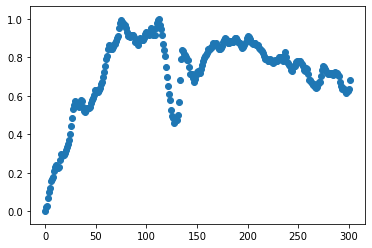

In [75]:
plt.figure()
plt.scatter(np.arange(0,len(screeningList[1][0])), screeningList[1][0])

/home/sof/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


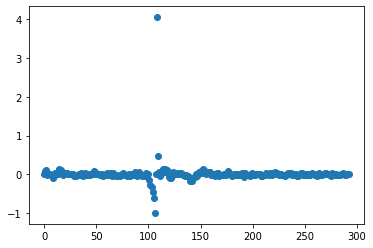

In [78]:
screening = screeningList[0]
percentageChange = np.array([np.divide(screening[0,x+1] - screening[0,x],screening[0,x]) for x in range(8,screening.shape[1]-1)])
percentageChange[np.isinf(percentageChange)] = 0

plt.figure()
plt.scatter(np.arange(0,len(percentageChange)), percentageChange)

In [87]:
screening[0][8:screening.shape[1]-1]

array([0.33847568, 0.34704626, 0.37390073, 0.41563571, 0.41123863,
       0.41834352, 0.42693894, 0.43101307, 0.4302678 , 0.38883092,
       0.37409947, 0.38597406, 0.39909077, 0.39991057, 0.40912704,
       0.46805286, 0.50991206, 0.56983157, 0.60503304, 0.59663636,
       0.60543052, 0.62890644, 0.64681771, 0.6635117 , 0.67374671,
       0.67859095, 0.69054007, 0.70348288, 0.72045014, 0.72909525,
       0.70927113, 0.67724947, 0.65367417, 0.64500422, 0.65178616,
       0.64982362, 0.66701446, 0.65586029, 0.63772544, 0.63737765,
       0.65769861, 0.65722661, 0.65541313, 0.64406022, 0.65322701,
       0.64820887, 0.6623938 , 0.6740945 , 0.68909922, 0.74750335,
       0.79852934, 0.8166145 , 0.83025289, 0.83944453, 0.85581557,
       0.85211408, 0.86048591, 0.8331346 , 0.8252596 , 0.82200527,
       0.83619019, 0.87072092, 0.86796343, 0.86282109, 0.88734039,
       0.87926666, 0.85454862, 0.88117951, 0.89310379, 0.88120435,
       0.84669846, 0.81919809, 0.79125056, 0.78804591, 0.74762

In [92]:
percentageChange*100

array([ 2.53211009e+00,  7.73801002e+00,  1.11620490e+01, -1.05791644e+00,
        1.72767911e+00,  2.05463183e+00,  9.54265099e-01, -1.72910663e-01,
       -9.63048499e+00, -3.78865321e+00,  3.17418155e+00,  3.39833945e+00,
        2.05415500e-01,  2.30463412e+00,  1.44028174e+01,  8.94326203e+00,
        1.17509500e+01,  6.17752202e+00, -1.38780538e+00,  1.47395595e+00,
        3.87755939e+00,  2.84800126e+00,  2.58094250e+00,  1.54255120e+00,
        7.19000037e-01,  1.76087275e+00,  1.87430298e+00,  2.41189350e+00,
        1.19995862e+00, -2.71900235e+00, -4.51472803e+00, -3.48103587e+00,
       -1.32634059e+00,  1.05145586e+00, -3.01101498e-01,  2.64546219e+00,
       -1.67225326e+00, -2.76504678e+00, -5.45362471e-02,  3.18821374e+00,
       -7.17658168e-02, -2.75929846e-01, -1.73217602e+00,  1.42328165e+00,
       -7.68206883e-01,  2.18832637e+00,  1.76642664e+00,  2.22590750e+00,
        8.47543170e+00,  6.82618810e+00,  2.26480836e+00,  1.67011438e+00,
        1.10708836e+00,  